# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import skimage.io
import tensorflow

np.set_printoptions(threshold=np.inf)
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class CarConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "5car"

    # Train on 3 GPU and 4 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 12 (GPUs * images/GPU).
    GPU_COUNT = 3
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # Background + 8 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape. 
    # DOES NOT WORK YET, WE Made all pictures 256x256 in preprocess
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.60
    
    #Higher learning rate should result in greater varaince in the begnning but better results
    GRADIENT_CLIP_NORM = 10
    LEARNING_RATE = 0.01
    
    #a Given from CPU and Image Count
    BATCH_SIZE = 12
    
config = CarConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     12
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      3
GRADIENT_CLIP_NORM             10
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [26]:
class CarDataset(utils.Dataset):

    def load_5car(self, dataset_dir, subset):
        """Load a subset of the 5car dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. 
        self.add_class("5car", 1, "part1")
        self.add_class("5car", 2, "part2")
        self.add_class("5car", 3, "part3")
        self.add_class("5car", 4, "part4")
        self.add_class("5car", 5, "part5")
        self.add_class("5car", 6, "part6")
        self.add_class("5car", 7, "part7")
        self.add_class("5car", 8, "part8")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        for filename in os.listdir(dataset_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = dataset_dir+"/"+filename
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]
        
                self.add_image(
                        source="5car",
                        image_id=filename,  # use file name as a unique image id
                        path=image_path,
                        width=width, height=height)
        

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        num_classes = 8 #TODO: add dynamic number of classes (8)
        
        # If not a 5car dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "5car":
            print("image not part of 5car dataset!!!!!!!!!!!!!!!!!!!")
            return super(self.__class__, self).load_mask(image_id)

        # Convert greyscale to binary multi layer image
        # Number of layers equal number of classes
        # [height, width, instance_count]

                    
                    
        info = self.image_info[image_id]
        dataset_dir = "./5car/mask/"
        imageX = skimage.io.imread(dataset_dir+str(info["id"]))            
        class_list = list(set(x for l in imageX for x in l))
        class_list.remove(0)
        mask_image=np.zeros([info["height"], info["width"], len(class_list)], 
                        dtype=np.uint8)
        for i,j in enumerate(imageX):
            for ii,jj in enumerate(j):
                if jj!= 0:
                    pixel=np.zeros(len(class_list))
                    pixel[class_list.index(jj)]=1
                    mask_image[i][ii]=pixel

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask_image.astype(np.bool), np.array(class_list, dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "5car":
            return info["path"]
        else:
            print("image not part of 5car dataset!!!!!!!!!!!!!!!!!!!")
            super(self.__class__, self).image_reference(image_id)

In [27]:
# Training dataset
dataset_train = CarDataset()
dataset_train.load_5car("./5car", "train")
dataset_train.prepare()

#TODO:change sources to be dynamic




# Validation dataset
dataset_val = CarDataset()
dataset_val.load_5car("./5car", "val")
dataset_val.prepare()

In [28]:

#print(dataset_train.load_image(1)) #original image
print(dataset_train.image_reference(3)) #binary mask for each element

./5car/train/trans_1116K1.png


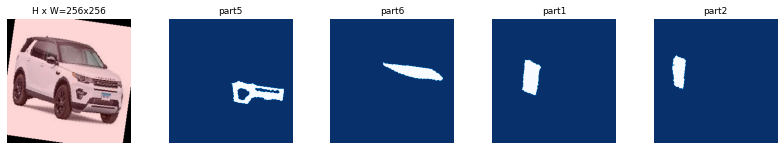

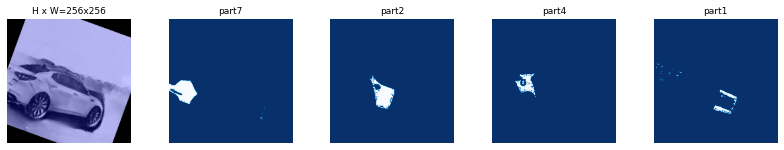

In [29]:
# Load and display random samples
image_ids = range(2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [30]:
tensorflow.version.VERSION

'1.14.0'

## Create Model

In [31]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [32]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 277


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE, 
#            epochs=1, 
#            layers='heads')

In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=490, 
            layers="all")


Starting at epoch 270. LR=0.001

Checkpoint Path: /zhome/04/7/127508/Desktop/Mask_RCNN-master/logs/5car20201130T1336/mask_rcnn_5car_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

KeyboardInterrupt: 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [33]:
class InferenceConfig(CarConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /zhome/04/7/127508/Desktop/Mask_RCNN-master/logs/5car20201130T1336/mask_rcnn_5car_0277.h5
Re-starting from epoch 277


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (3,)                  min:    5.00000  max:    7.00000  int32
gt_bbox                  shape: (3, 4)                min:   34.00000  max:  181.00000  int32
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:    1.00000  bool


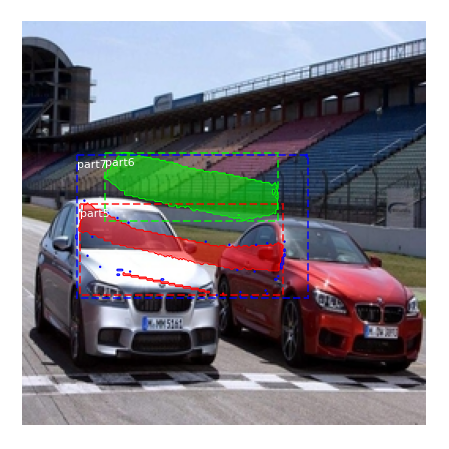

In [38]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
image_id = 22 #cat
#image_id = 10 #cactus
image_id = 17 #two cars
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


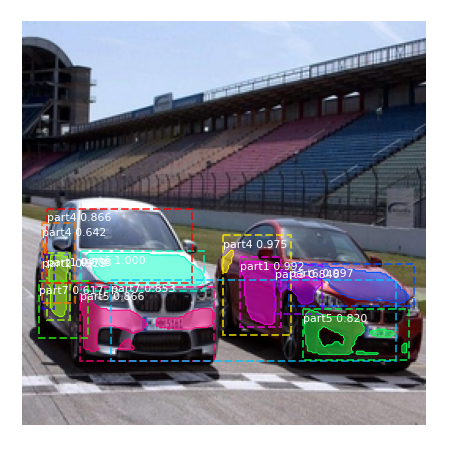

In [39]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))